# 1. Creacion de base de datos 
Para crear la base de datos utilizamos sqlite3. El objetivo es podernos conectar y crear automaticamente una base de datos cada que ejectuemos este notebook.

### Importamos librerias

In [1]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Creamos la conexión y el cursor
Esto nos permitirá llamar a la base de datos para realizar las queries requeridas

In [2]:
# Ruta donde se almacenará la base de datos
db_path = './db/bca_operations.db'

# Eliminar la base de datos si ya existe
if os.path.exists(db_path):
    os.remove(db_path)

Creamos una conexión con la base de datos y un cursos para interactuar con ella desde Python

In [3]:
# Conectar a la base de datos SQLite e inicializar el cursor
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

## Creamos las tablas de la base de datos
Aquí se almacenará toda la información de los csv

Notas:
- Se habilitan las foreign_keys para la base de datos, en caso de que no estén habilitadas por defecto
- Se añaden primary_keys a las tablas que no cuenten con ellas.
- Se añaden las columnas "created_at" y "updated_at" siguiendo las buenas prácticas de DBA.
- Se crean índices para optimizar las futuras queries, siguiendo buenas prácticas.

In [4]:
# Habilitar claves foraneas: 
cursor.execute("PRAGMA foreign_keys = ON;")

# Crear tablas y relacionarlas con claves foraneas
cursor.execute(
    '''
    CREATE TABLE IF NOT EXISTS dim_players (
        player_id VARCHAR(50) PRIMARY KEY,
        name VARCHAR(256),
        registration_date DATE,
        country VARCHAR(50),
        created_at DATETIME DEFAULT (datetime('now')),
        updated_at DATETIME DEFAULT (datetime('now'))
    );
'''
)

cursor.execute('''
CREATE TABLE IF NOT EXISTS fact_deposits (
    deposit_id VARCHAR(50) PRIMARY KEY,
    player_id VARCHAR(50),
    deposit_amount DECIMAL(10, 2),
    deposit_date DATE,
    created_at DATETIME DEFAULT (datetime('now')),
    updated_at DATETIME DEFAULT (datetime('now')),
    FOREIGN KEY (player_id) REFERENCES dim_players(player_id)
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS fact_traffic_sources (
    traffic_id INTEGER PRIMARY KEY AUTOINCREMENT,
    player_id VARCHAR(50),
    trafficker VARCHAR(50),
    cost_of_acquisition DECIMAL(10, 2),
    registration_date DATE,
    created_at DATETIME DEFAULT (datetime('now')),
    updated_at DATETIME DEFAULT (datetime('now')),
    FOREIGN KEY (player_id) REFERENCES dim_players(player_id)
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS internal_records (
    record_id INTEGER PRIMARY KEY AUTOINCREMENT,
    month VARCHAR(10),
    expected_ftd INTEGER,
    expected_cpa INTEGER 
);
''')

In [5]:

# Crear índices para optimizar consultas
cursor.execute('CREATE INDEX IF NOT EXISTS idx_fact_deposits_player_id ON fact_deposits(player_id);')
cursor.execute('CREATE INDEX IF NOT EXISTS idx_fact_traffic_sources_player_id ON fact_traffic_sources(player_id);')
cursor.execute('CREATE INDEX IF NOT EXISTS idx_fact_deposits_date ON fact_deposits(deposit_date);')


# 2. Carga de datos
Se leen los csv para cargar su contenido a las tablas ya creadas

In [6]:
# Cargar los CSV en DataFrames
players_df = pd.read_csv('./source/players.csv')
deposits_df = pd.read_csv('./source/deposits.csv')
traffic_sources_df = pd.read_csv('./source/traffic_sources.csv')
internal_records_df = pd.read_csv('./source/internal_records.csv')

In [7]:
# Insertar datos en las tablas
players_df.to_sql('dim_players', conn, if_exists='append', index=False)
deposits_df.to_sql('fact_deposits', conn, if_exists='append', index=False)
traffic_sources_df.to_sql('fact_traffic_sources', conn, if_exists='append', index=False)
internal_records_df.to_sql('internal_records', conn, if_exists='append', index=False)

print(f"Base de datos creada exitosamente en {db_path}")

Base de datos creada exitosamente en ./db/bca_operations.db


# 3. Consultas iniciales


### Identificación de status de jugadores como FTD y CPA
Aquí creamos un Dataframe usando Pandas, en el cuál reúnimos información relevante sobre cada jugador y su status como FTD y CPA

In [8]:
# Generar un reporte con los datos de los jugadores y sus depósitos
player_status_df = pd.read_sql_query('''
SELECT 
    dp.player_id,
    dp.name,   -- Datos del jugador
    dp.registration_date,    -- Fecha de registro
    MIN(fd.deposit_date) AS first_deposit_date,   -- Fecha del primer depósito
    MIN(fd.deposit_amount) AS first_deposit_amount,   -- Monto del primer depósito
    SUM(fd.deposit_amount) AS total_deposit_amount,  -- Monto total depositado
    CASE WHEN MIN(fd.deposit_date) IS NOT NULL THEN 'FTD' ELSE 'No FTD' END AS ftd_status,  -- Si ya hizo su primer depósito
    CASE WHEN SUM(fd.deposit_amount) > 100 THEN 'CPA' ELSE 'No CPA' END AS cpa_status  -- Condición de CPA según monto total depositado
FROM dim_players dp
LEFT JOIN fact_deposits fd ON dp.player_id = fd.player_id
GROUP BY dp.player_id, dp.name;
''', conn
)

### Creación de Dataframe con FTD y CPA por mes
Aquí, creamos un Dataframe que contiene el conteo por mes de:
- FTD: jugadores que realizaron su primer depósito
- CPA_ Jugadores cuyo status pasó a ser CPA, es decir, cuyos depósitos acumulados superaron los 100USD

In [9]:
analysis_records_df = pd.read_sql_query('''
    WITH      
        first_deposit AS (    -- Identificamos el primer depósito de cada jugador
            SELECT 
                player_id,
                MIN(deposit_date) AS first_deposit_date
            FROM fact_deposits
            GROUP BY player_id    -- Agrupamos por jugador para obtener un solo registro por jugador
        ),          
        ftd_per_month AS (    -- Calculamos el número de FTD por mes
            SELECT 
                strftime('%Y-%m', first_deposit_date) AS month,
                COUNT(DISTINCT player_id) AS ftd_count    -- Contamos jugadores únicos que hicieron su primer depósito en cada mes
            FROM first_deposit
            GROUP BY month
        ),
        player_deposits AS (    -- Calculamos depósitos acumulativos para cada jugador
            SELECT 
                player_id,
                deposit_date,
                deposit_amount,
                SUM(deposit_amount) OVER (    -- Generamos un acumulado de los depósitos ordenados por fecha
                    PARTITION BY player_id    -- Reseteamos el acumulado para cada jugador
                    ORDER BY deposit_date ASC    -- Ordenamos los depósitos por fecha para asegurar la acumulación correcta
                ) AS cumulative_deposit
            FROM fact_deposits
        ),
        first_cpa AS (    -- Identificamos la fecha en la que los jugadores alcanzaron la categoría CPA
            SELECT 
                player_id,
                MIN(deposit_date) AS first_cpa_date    -- La primera fecha en la que el jugador superó los 100 USD acumulados
            FROM player_deposits
            WHERE cumulative_deposit > 100    -- Consideramos solo los jugadores que han alcanzado el umbral de CPA
            GROUP BY player_id
        ),
        cpa_per_month AS (    -- Calculamos el número de CPA por mes
            SELECT 
                strftime('%Y-%m', first_cpa_date) AS month,
                COUNT(player_id) AS cpa_count    --Contamos jugadores que alcanzaron CPA en cada mes
            FROM first_cpa
            GROUP BY month
        )
    SELECT    -- Unimos los resultados de FTD y CPA por mes en una sola tabla
        ftd.month AS month,    -- Mes correspondiente al primer depósito
        ftd.ftd_count AS ftd_count,    -- Número de jugadores FTD en ese mes
        COALESCE(cpa.cpa_count, 0) AS cpa_count    -- Número de jugadores CPA en ese mes (0 si no hay CPA para ese mes)
    FROM ftd_per_month ftd
    LEFT JOIN cpa_per_month cpa ON ftd.month = cpa.month    -- Incluimos todos los meses de FTD aunque no tengan CPA
    ORDER BY ftd.month;    -- Ordenamos los resultados cronológicamente
''', conn
)

# 4. Comparativa internal_records y analysis_records
Aquí compararemos los datos del reporte interno (internal_records_df) sobre los FTD y CPA esperados por mes, con los datos obtenidos de la tabla deposits en el reporte de analisis (analysis_records_df)

Primero, realizaremos una modificación en las columnas month de internal_records_df y de analysis_records_df, pues ambas son tipo texto en formato yyyy-mm, y las transformaremos en tipo date con formato yyyy-mm-dd para facilitar su análisis 

In [10]:
#Cambiamos el tipo de dato de la columna 'month' a datetime y agregamos el día 01
internal_records_df['month'] = pd.to_datetime(internal_records_df['month'] + '-01')
analysis_records_df['month'] = pd.to_datetime(analysis_records_df['month'] + '-01')

Adicionalmente, crearemos un Dataframe llamado all_months, que cubra todos los meses desde enero del 2022 hasta diciembre del 2023, y lo uniremos a internal_records, para asegurar que este Dataframe tiene un conteo completo de los meses y no se salte ninguno. Esto es indispensable para que los futuros análisis o visualizaciones tengan información completa y no salten meses.

In [11]:
# Crear un rango completo de meses desde el mínimo hasta el máximo mes
all_months = pd.date_range(
    start=analysis_records_df['month'].min(),
    end=analysis_records_df['month'].max(),
    freq='MS'
)

# Convertir a DataFrame para usar en el merge
all_months_df = pd.DataFrame({'month': all_months})

# Realizar el merge asegurando que ambos DataFrames usan datetime
analysis_records_df = all_months_df.merge(
    analysis_records_df, 
    on='month', 
    how='left'
)

# Convertir las fechas al formato yyyy-mm-dd al final
analysis_records_df['month'] = analysis_records_df['month'].dt.strftime('%Y-%m-%d')

# Reemplazar valores nulos por 0
analysis_records_df.fillna(0, inplace=True)

# Reconversión a datetime para asegurar compatibilidad con el formato de fecha
analysis_records_df['month'] = pd.to_datetime(analysis_records_df['month'])

Unimos ambos reportes y reemplazamos los valores posibles valores nulos con 0, haciendo referencia a que allí no hubo FTDs y/o CPAs.

In [12]:
# Unimos los DataFrames internal_records_df y analysis_records_df
combined_records_df = internal_records_df.merge(
    analysis_records_df, 
    on='month', 
    how='inner',
    suffixes=('_internal', '_calculated')
)

# Reemplazamos valores nulos por 0, si lo shay
combined_records_df.fillna(0, inplace=True)

Creamos columnas extras, donde se registra la diferencia entre expected_fda y fda_count, y entre expected_cpa y cpa_count

In [13]:
combined_records_df['ftd_difference'] = (combined_records_df['ftd_count'] - combined_records_df['expected_ftd'])
combined_records_df['cpa_difference'] = (combined_records_df['cpa_count'] - combined_records_df['expected_cpa'])

# 5. Análisis y visualizaciones 

### FTD y CPA Esperado vs Real

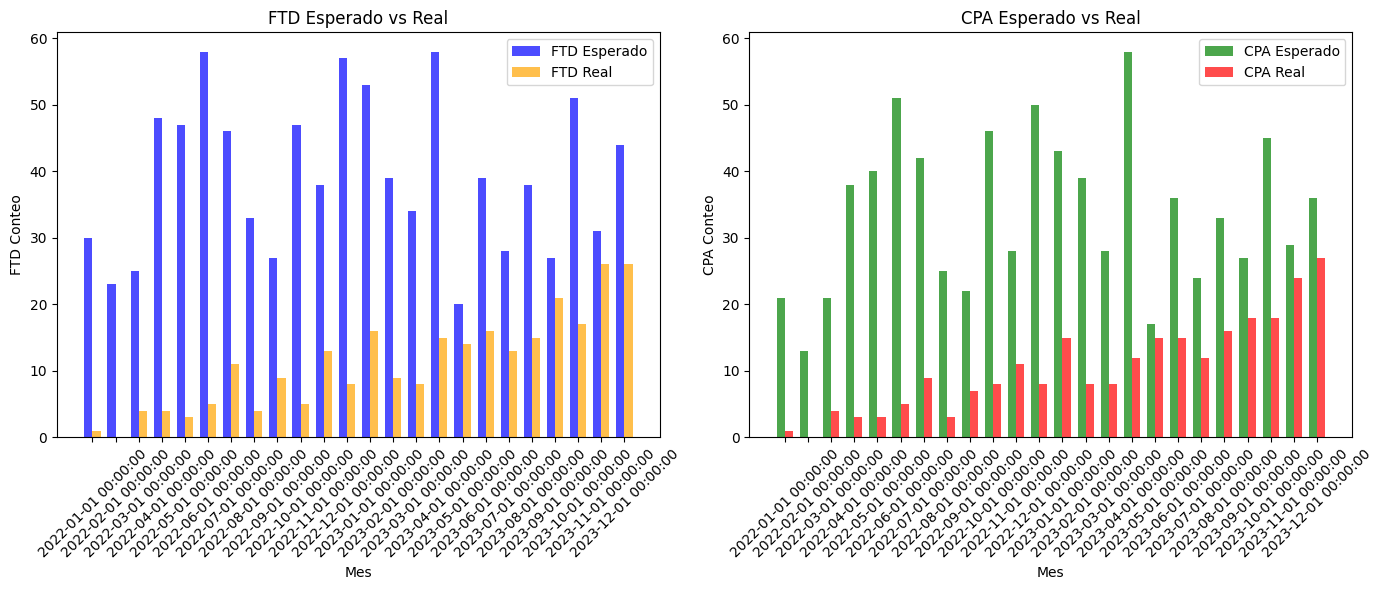

In [14]:
# Visualizar las diferencias en FTD y CPA por mes
# Verificamos que merged_df contiene las columnas esperadas y graficamos los valores esperados y reales.
def plot_discrepancies(merged_df):
    plt.figure(figsize=(14, 6))

    # Gráfico combinado para FTD
    plt.subplot(1, 2, 1)
    width = 0.35  # Ancho de las barras
    months = merged_df['month']
    x = range(len(months))

    plt.bar(x, merged_df['expected_ftd'], width, label='FTD Esperado', alpha=0.7, color='blue')
    plt.bar([p + width for p in x], merged_df['ftd_count'], width, label='FTD Real', alpha=0.7, color='orange')

    plt.xlabel('Mes')
    plt.ylabel('FTD Conteo')
    plt.title('FTD Esperado vs Real')
    plt.xticks([p + width / 2 for p in x], months, rotation=45)
    plt.legend()

    # Gráfico combinado para CPA
    plt.subplot(1, 2, 2)
    plt.bar(x, merged_df['expected_cpa'], width, label='CPA Esperado', alpha=0.7, color='green')
    plt.bar([p + width for p in x], merged_df['cpa_count'], width, label='CPA Real', alpha=0.7, color='red')

    plt.xlabel('Mes')
    plt.ylabel('CPA Conteo')
    plt.title('CPA Esperado vs Real')
    plt.xticks([p + width / 2 for p in x], months, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_discrepancies(combined_records_df)

#### Extra: Proporción de CPA vs No CPA

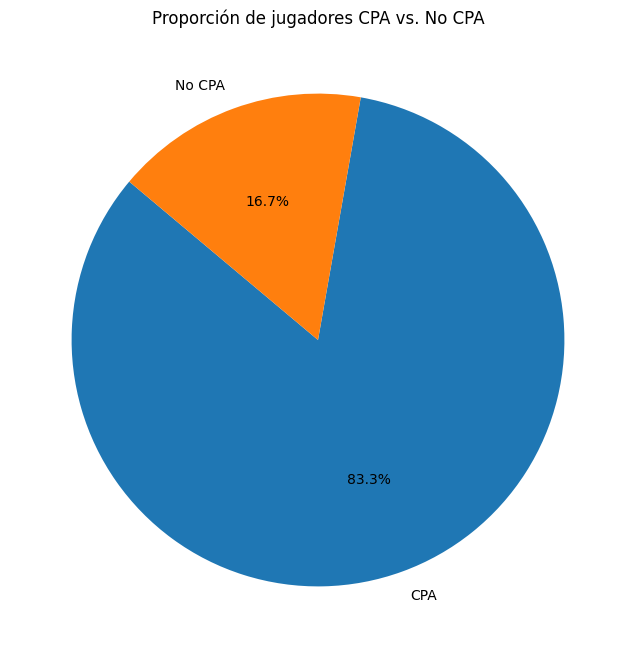

In [15]:
# Proporción de jugadores CPA vs. no CPA
def plot_cpa_proportion(df_player_status):
    # Contar los valores de CPA vs No CPA
    cpa_counts = df_player_status['cpa_status'].value_counts()

    # Crear el gráfico de pastel
    plt.figure(figsize=(8, 8))
    plt.pie(cpa_counts, labels=cpa_counts.index, autopct='%1.1f%%', startangle=140, colors=['#1f77b4', '#ff7f0e'])
    plt.title('Proporción de jugadores CPA vs. No CPA')
    plt.show()

plot_cpa_proportion(player_status_df)

### Histórico de depósitos por mes

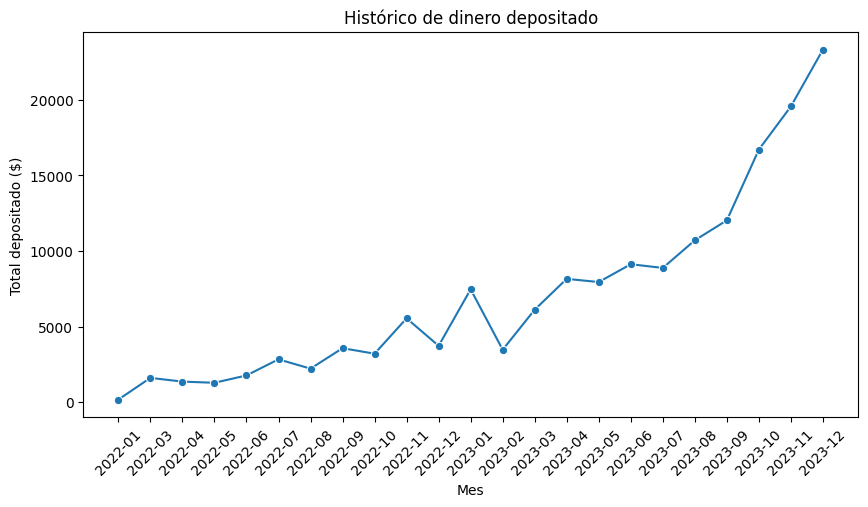

In [16]:
# Graficar el histórico de dinero depositado por mes
def plot_historical_deposits(deposits_df):
    deposits_df['month'] = pd.to_datetime(deposits_df['deposit_date']).dt.to_period('M')
    historical_deposits = deposits_df.groupby('month')['deposit_amount'].sum().reset_index()
    historical_deposits['month'] = historical_deposits['month'].astype(str)

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=historical_deposits, x='month', y='deposit_amount', marker='o')
    plt.title('Histórico de dinero depositado')
    plt.ylabel('Total depositado ($)')
    plt.xlabel('Mes')
    plt.xticks(rotation=45)
    plt.show()

plot_historical_deposits(deposits_df)

### Jugador con mayor monto depositado

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13988\4158694163.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_player_deposits, x='deposit_date', y='deposit_amount', palette='Blues_d')


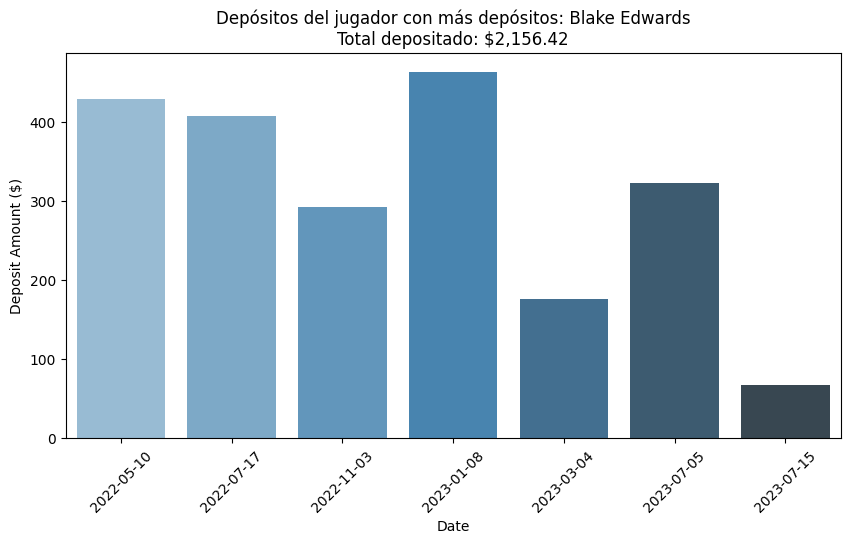

In [17]:
# Identificar y graficar los datos del jugador con más dinero depositado
def plot_top_player(deposits_df, players_df):
    # Unir deposits_df con players_df para obtener el nombre del jugador
    deposits_with_names = deposits_df.merge(players_df[['player_id', 'name']], on='player_id', how='left')

    # Identificar el jugador con más depósitos
    top_player = deposits_with_names.groupby('player_id')['deposit_amount'].sum().idxmax()
    top_player_name = deposits_with_names[deposits_with_names['player_id'] == top_player]['name'].iloc[0]
    top_player_deposits = deposits_with_names[deposits_with_names['player_id'] == top_player]

    # Calcular el monto total depositado por el jugador
    total_deposit = top_player_deposits['deposit_amount'].sum()

    # Ordenar los depósitos por fecha ascendente
    top_player_deposits = top_player_deposits.sort_values(by='deposit_date')

    # Crear el gráfico
    plt.figure(figsize=(10, 5))
    sns.barplot(data=top_player_deposits, x='deposit_date', y='deposit_amount', palette='Blues_d')
    plt.title(f'Depósitos del jugador con más depósitos: {top_player_name}\nTotal depositado: ${total_deposit:,.2f}')
    plt.ylabel('Deposit Amount ($)')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.show()


plot_top_player(deposits_df, players_df)

### Jugadores por trafficker

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13988\2336832471.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=players_by_trafficker, x='trafficker', y='player_id', palette='Blues_d')


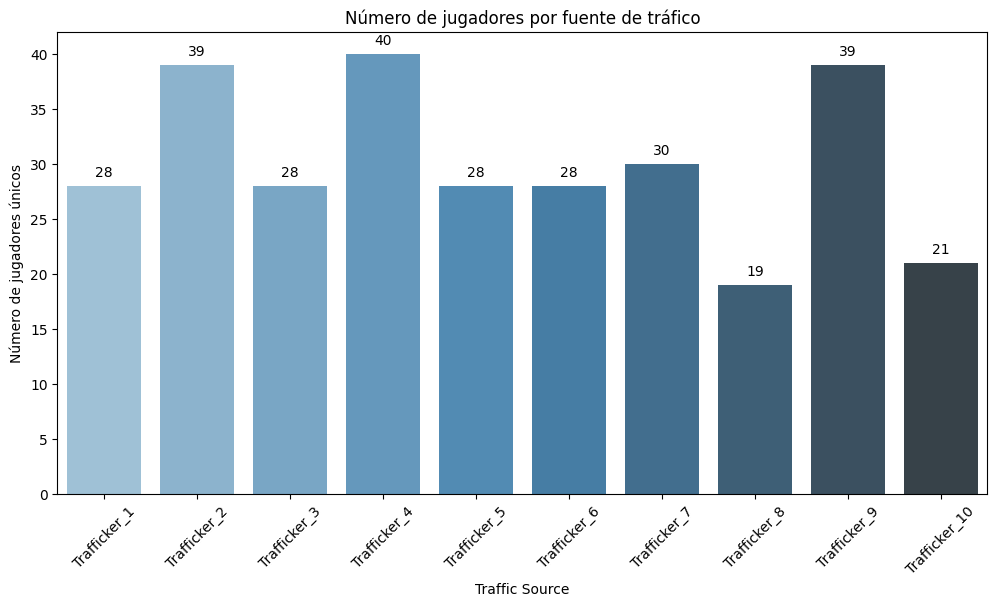

In [18]:
# Graficar número de jugadores por fuente de tráfico
def plot_players_by_trafficker(traffic_sources_df):
    # Contar el número de jugadores por fuente de tráfico
    players_by_trafficker = traffic_sources_df.groupby('trafficker')['player_id'].nunique().reset_index()

    # Extraer el número de trafficker para ordenarlo correctamente
    players_by_trafficker['trafficker_number'] = players_by_trafficker['trafficker'].str.extract(r'(\d+)').astype(int)
    players_by_trafficker = players_by_trafficker.sort_values(by='trafficker_number')

    # Crear el gráfico
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=players_by_trafficker, x='trafficker', y='player_id', palette='Blues_d')
    
    # Añadir los valores encima de cada barra
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    fontsize=10, color='black', xytext=(0, 5), 
                    textcoords='offset points')

    plt.title('Número de jugadores por fuente de tráfico')
    plt.ylabel('Número de jugadores únicos')
    plt.xlabel('Traffic Source')
    plt.xticks(rotation=45)
    plt.show()


plot_players_by_trafficker(traffic_sources_df)

# 6. Output
Una vez realizados los análisis, exportamos los Dataframes relevantes como archivos csv y cerramos la conexión con la Base de datos

In [19]:
# Creamos un guardian para evitar errores de lectura de punto flotante
player_status_df['total_deposit_amount'] = player_status_df['total_deposit_amount'].round(2)

# Exportar DataFrames seleccionados
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

# Exportamos los Dataframes creados
player_status_df.to_csv(os.path.join(output_dir, 'player_status.csv'), index=False) #, float_format='%.2f')
analysis_records_df.to_csv(os.path.join(output_dir, 'ftd_cpa_by_month.csv'), index=False)
combined_records_df.to_csv(os.path.join(output_dir, 'combined_records.csv'), index=False)

# Añadimos internal_records_df aprovechando las transformaciones realizadas
internal_records_df.to_csv(os.path.join(output_dir, 'internal_records.csv'), index=False)

# Mostrar resultados
print(f"Exportación completada. Archivos guardados en la carpeta {output_dir}.")

Exportación completada. Archivos guardados en la carpeta ./output.


In [20]:
# Confirmar cambios y cerrar conexión
conn.commit()
conn.close()
